In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from collections import defaultdict

from surprise.model_selection import KFold

from surprise.model_selection.validation  import cross_validate
from surprise.prediction_algorithms.knns import KNNWithMeans

import os
from surprise import Dataset
from surprise import Reader
from surprise import accuracy

from surprise.model_selection import train_test_split

from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
# Helper methods
def plot_histogram(ydata, x_labels = [0.01, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], title = 'Generic Title', x_label= 'x_label', y_label='y_label'):
    plt.gcf().clear()
    plt.hist(ydata, bins=x_labels, ec='black')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()   

def plot_distribution(ydata,xdata=None, title='Generic Distribution', x_label='Generic', y_label='Generic'):
    plt.gcf().clear()
    if xdata is None:
        plt.plot(ydata)
    else:
        plt.plot(xdata,ydata) 
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show() 
    
def popular_movies_filtered(testset, freq_movies):
    filtered = np.where(freq_movies >2)[0]
    
    #remove in testset
    filtered_testset = []
    for i in range(len(testset)):
        if int(testset[i][1]) in filtered:
            filtered_testset.append(testset[i])
    return filtered_testset

def unpopular_movies_filtered(testset, freq_movies):
    filtered = np.where(freq_movies <=2)[0]
    
    #remove in testset
    filtered_testset = []
    for i in range(len(testset)):
        if int(testset[i][1]) in filtered:
            filtered_testset.append(testset[i])
    return filtered_testset

def high_var_movies_filtered(testset, freq_movies, high_var_movies):
    filtered = np.where(freq_movies >=5)[0]
    filtered_var = np.where(high_var_movies>=2)[0]
    
    #remove in testset
    filtered_testset = []
    for i in range(len(testset)):
        if int(testset[i][1]) in filtered and int(testset[i][1]) in filtered_var:
            filtered_testset.append(testset[i])
    return filtered_testset

def combined_roc_plotter(fprs, tprs, aucs, rt_th):
    plt.gcf().clear()
    plt.figure(figsize=(12,9))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC Curve', fontsize=23)
    for i in range(len(fprs)):
        plt.plot(fprs[i],tprs[i], label = 'ROC Curve: Threshold: {rt} AUC: {auc}'.format(rt=rt_th[i], auc=aucs[i]) )
    plt.legend(loc="lower right")
    plt.show()

In [4]:
Ratings = pd.read_csv('ml-latest-small/ratings.csv')


In [5]:
Ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
# For the subsequent discussion,
# we assume that the ratings matrix is denoted by R, and it is an m  n matrix
# containing m users (rows) and n movies (columns).

R_df = Ratings.pivot_table('rating', 'userId', 'movieId', fill_value=0)


In [7]:
R_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0


In [8]:
# Question 1: Compute the sparsity of the movie rating dataset, where spar-
# sity is defined by equation 1

# total available rating = 10004, total possible rating = R(len) * R(width)

total_available_rating = len(Ratings) # = 10004
total_possible_ratings =np.prod(R_df.shape)

sparsity = total_available_rating / total_possible_ratings

print('Question 1: Sparsity =', sparsity)

Question 1: Sparsity = 0.0164391416087


In [9]:
# Question 2: Plot a histogram showing the frequency of the rating values. To
# be specific, bin the rating values into intervals of width 0.5 and use the binned
# rating values as the horizontal axis. Count the number of entries in the ratings
# matrix R with rating values in the binned intervals and use this count as the
# vertical axis. Briely comment on the shape of the histogram


In [10]:
Ratings.rating.unique()

array([ 2.5,  3. ,  2. ,  4. ,  3.5,  1. ,  5. ,  4.5,  1.5,  0.5])

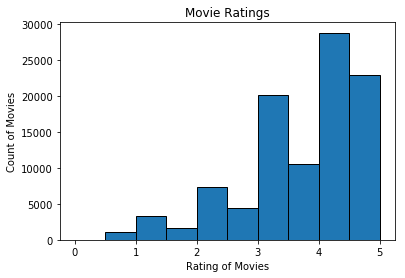

In [11]:
plot_histogram(ydata = Ratings.rating, title='Movie Ratings', x_label='Rating of Movies', y_label='Count of Movies')

In [12]:
# Question 3: Plot the distribution of ratings among movies. To be specific,
# the X-axis should be the movie index ordered by decreasing frequency and the
# Y -axis should be the number of ratings the movie has received.

In [13]:
frequency_movies = np.sum(R_df!=0, axis=0) # we need to do R_df!=0 to not consider users not giving rating to a movie
movie_sorted = frequency_movies.sort_values(ascending=False)

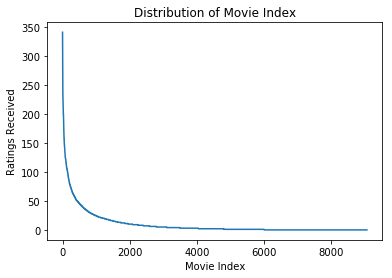

In [14]:
plot_distribution(ydata=list(movie_sorted), title='Distribution of Movie Index', x_label='Movie Index', y_label='Ratings Received')

In [15]:
# Question 4: Plot the distribution of ratings among users. To be specifc, the
# X-axis should be the user index ordered by decreasing frequency and the Y -axis
# should be the number of movies the user have rated.

In [16]:
frequency_users = np.sum(R_df!=0, axis=1) # we need to do R_df!=0 to not consider users not giving rating to a movie
user_sorted = frequency_users.sort_values(ascending=False)

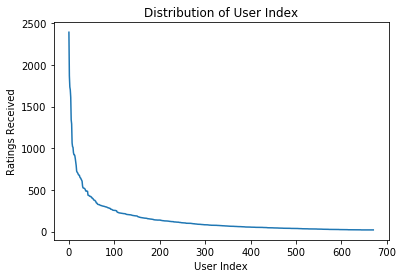

In [17]:
plot_distribution(ydata=list(user_sorted), title='Distribution of User Index', x_label='User Index', y_label='Ratings Received')

In [18]:
# Question 5: Explain the salient features of the distribution found in question 3
# and their implications for the recommendation process.

In [19]:
# Question 6: Compute the variance of the rating values received by each movie.
# Then, bin the variance values into intervals of width 0.5 and use the binned vari-
# ance values as the horizontal axis. Count the number of movies with variance
# values in the binned intervals and use this count as the vertical axis. Briely
# comment on the shape of the histogram

In [20]:
R_df_na = Ratings.pivot_table('rating', 'userId', 'movieId') # no rating as nan
var_movie = np.var(R_df_na,axis=0)

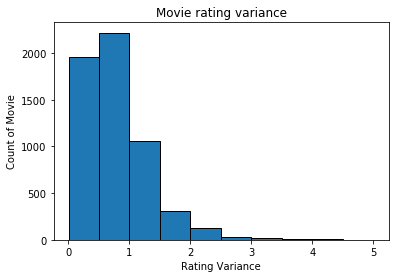

In [21]:
plot_histogram(ydata = var_movie, title="Movie rating variance", x_label="Rating Variance",y_label="Count of Movie" )

In [22]:
# Question 7: Write down the formula for u in terms of Iu and ruk

In [23]:
# Question 8: In plain words, explain the meaning of Iu \ Iv. Can Iu \ Iv = ;

In [24]:
# Question 9: Can you explain the reason behind mean-centering the raw rat-
# ings (rvj 􀀀 v) in the prediction function? (Hint: Consider users who either
# rate all items highly or rate all items poorly and the impact of these users on
# the prediction function)

In [25]:
# Question 10: Design a k-NN collaborative filter to predict the ratings of the

In [26]:
#required in order to input rating
reader = Reader(rating_scale=(0.5, 5))
ratings_surprise_dataset = Dataset.load_from_df(Ratings[['userId','movieId','rating']], reader)

In [27]:
%%capture
RMSE = []
MAE = []
knn_ks = np.arange(2,102,2)

for k in range(2,102,2):
    knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
    cv = cross_validate(knn, ratings_surprise_dataset, measures=['RMSE','MAE'],cv=10, verbose=False)
    RMSE.append(np.mean(cv['test_rmse']))
    MAE.append(np.mean(cv['test_mae']))
                

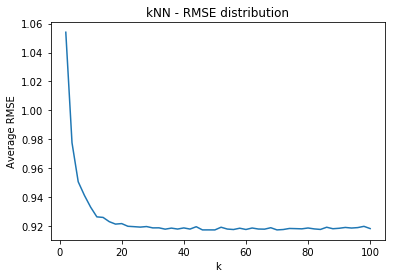

In [28]:
plot_distribution(RMSE, knn_ks, title="kNN - RMSE distribution", x_label="k", y_label="Average RMSE")

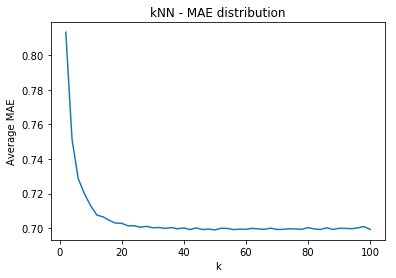

In [29]:
plot_distribution(MAE, knn_ks, title="kNN - MAE distribution", x_label="k", y_label="Average MAE")

In [30]:
# Question 11: Use the plot from question 10, to find a 'minimum k'. Note: The
# term 'minimum k' in this context means that increasing k above the minimum
# value would not result in a significant decrease in average RMSE or average
# MAE. If you get the plot correct, then 'minimum k' would correspond to the
# k value for which average RMSE and average MAE converges to a steady-state
# value. Please report the steady state values of average RMSE and average MAE

In [31]:
#position where min RMSE
min_RMSE = [i for i, x in enumerate(RMSE) if x == min(RMSE)]
print(min(RMSE))
print(knn_ks[min_RMSE]) #lowest k value

0.917193152964
[50]


In [32]:
#position where min MAE
min_MAE = [i for i, x in enumerate(MAE) if x == min(MAE)]
print(min(MAE))
print(knn_ks[min_MAE]) # lowest k value

0.698990871705
[50]


In [33]:
# Question 12: Design a k-NN collaborative filter to predict the ratings of the
# movies in the popular movie trimmed test set and evaluate it's performance
# using 10-fold cross validation.Sweep k ( number of neighbors) from 2 to 100 in
# step sizes of 2, and for each k compute the average RMSE obtained by averaging
# the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
# Also, report the minimum average RMSE

In [34]:
from surprise.model_selection import KFold
# frequency_movies

In [35]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_pop_movies_filtered = []
for k in range(2,102,2):
    knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        knn.fit(trainset)
        filtered_testset = popular_movies_filtered(testset, frequency_movies)
        pred = knn.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_pop_movies_filtered.append(np.mean(temp_rsme))

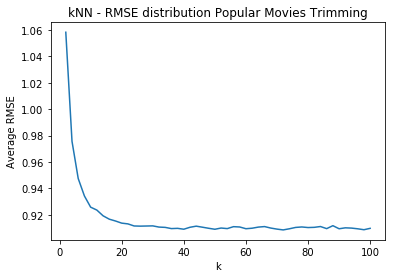

In [36]:
plot_distribution(RMSE_pop_movies_filtered,knn_ks, title="kNN - RMSE distribution Popular Movies Trimming", x_label="k", y_label="Average RMSE")


In [37]:
# Question 13: Design a k-NN collaborative filter to predict the ratings of the
# movies in the unpopular movie trimmed test set and evaluate it's performance
# using 10-fold cross validation.Sweep k ( number of neighbors) from 2 to 100 in
# step sizes of 2, and for each k compute the average RMSE obtained by averaging
# the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
# Also, report the minimum average RMSE

In [38]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_unpop_movies_filtered = []
for k in range(2,102,2):
    knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        knn.fit(trainset)
        filtered_testset = unpopular_movies_filtered(testset, frequency_movies)
        pred = knn.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_unpop_movies_filtered.append(np.mean(temp_rsme))

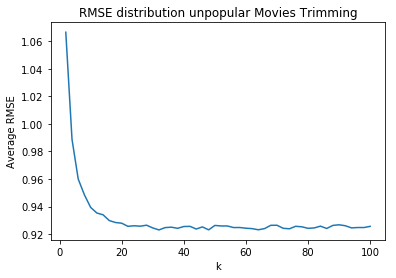

In [39]:
plot_distribution(RMSE_unpop_movies_filtered,knn_ks, title="RMSE distribution unpopular Movies Trimming", x_label="k", y_label="Average RMSE")


In [40]:
# Question 14: Design a k-NN collaborative filter to predict the ratings of the
# movies in the high variance movie trimmed test set and evaluate it's perfor-
# mance using 10-fold cross validation.Sweep k ( number of neighbors) from 2 to
# 100 in step sizes of 2, and for each k compute the average RMSE obtained by
# averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k
# (X-axis). Also, report the minimum average RMSE

In [41]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_high_var_movies_filtered = []
high_variance_movies = np.var(R_df_na, axis=0)
for k in range(2,102,2):
    knn = KNNWithMeans(k=k, sim_options = {'name': 'pearson'})
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        knn.fit(trainset)
        filtered_testset = high_var_movies_filtered(testset, frequency_movies, high_variance_movies)
        pred = knn.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_high_var_movies_filtered.append(np.mean(temp_rsme))

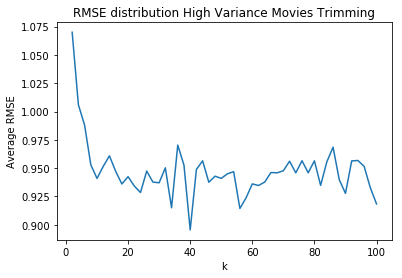

In [42]:
plot_distribution(RMSE_high_var_movies_filtered,knn_ks, title="RMSE distribution High Variance Movies Trimming", x_label="k", y_label="Average RMSE")


In [43]:
# Question 15: Plot the ROC curves for the k-NN collaborative filter designed
# in question 10 for threshold values [2:5; 3; 3:5; 4]. For the ROC plotting use the
# k found in question 11. For each of the plots, also report the area under the
# curve (AUC) value.

In [44]:
ratings_thresholds = [2.5,3,3.5,4]

fprs = []
tprs = []
AUCs = []

for threshold in ratings_thresholds:
    knn = KNNWithMeans(k=min_RMSE[0], sim_options={'name': 'pearson'}) #min_RSME is from problem 11.
    trainset, testset = train_test_split(ratings_surprise_dataset, test_size=0.1)
    knn.fit(trainset)
    pred = knn.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold: #ratings threshold
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    fprs.append(fpr)
    tprs.append(tpr)
    AUCs.append(AUC)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


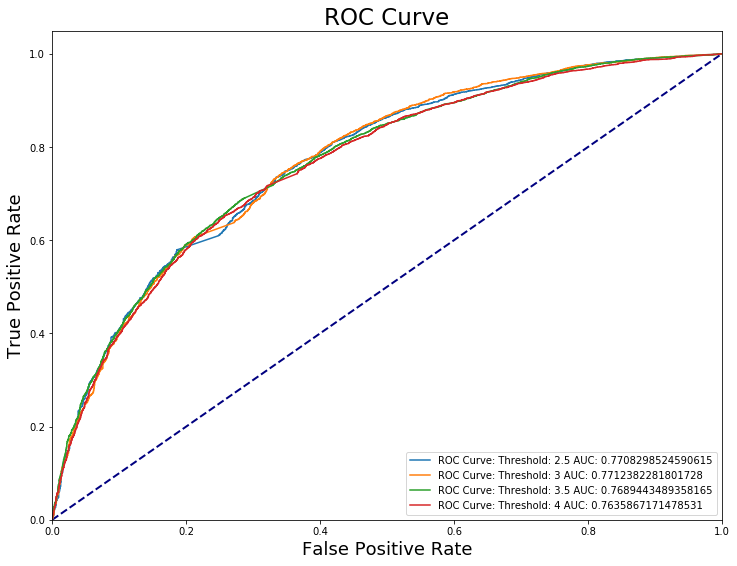

In [45]:
combined_roc_plotter(fprs,tprs,AUCs,ratings_thresholds)

In [46]:
# Question 16: Is the optimization problem given by equation 5 convex? Consider
# the optimization problem given by equation 5. For U fixed, formulate it as a
# least-squares problem.

In [47]:
# Question 17: Design a NNMF-based collaborative filter to predict the ratings of
# the movies in the MovieLens dataset and evaluate it's performance using 10-fold
# cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes
# of 2, and for each k compute the average RMSE and average MAE obtained
# by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE
# (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis).
# For solving this question, use the default value for the regularization parameter.

In [48]:
from surprise.prediction_algorithms.matrix_factorization import NMF

In [49]:
#ratings_surprise_dataset

In [50]:
# NMFs
nmf_ks = np.arange(2,52,2)
nmf_mae, nmf_rmse = [],[]
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=False)
    cv = cross_validate(nmf, ratings_surprise_dataset,measures=['RMSE','MAE'],cv=10, verbose=False)
    nmf_rmse.append(np.mean(cv['test_rmse']))
    nmf_mae.append(np.mean(cv['test_mae']))
    
    
    

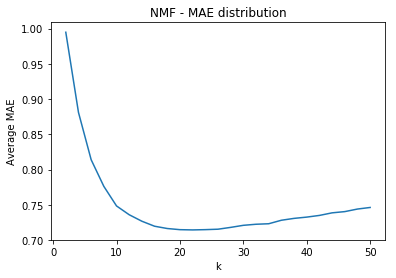

In [51]:
plot_distribution(nmf_mae, nmf_ks, title="NMF - MAE distribution", x_label="k", y_label="Average MAE")

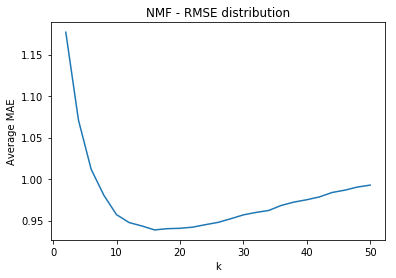

In [52]:
plot_distribution(nmf_rmse, nmf_ks, title="NMF - RMSE distribution", x_label="k", y_label="Average MAE")

In [53]:
# Question 18: Use the plot from question 17, to find the optimal number of
# latent factors. Optimal number of latent factors is the value of k that gives
# the minimum average RMSE or the minimum average MAE. Please report the
# minimum average RMSE and MAE. Is the optimal number of latent factors
# same as the number of movie genres?

In [54]:
#position where min RMSE
nmf_min_RMSE = [i for i, x in enumerate(nmf_rmse) if x == min(nmf_rmse)]
print(min(nmf_rmse))
print(nmf_ks[nmf_min_RMSE]) #lowest k value

0.938755855679
[16]


In [55]:
#position where min MAE
nmf_min_MAE = [i for i, x in enumerate(nmf_mae) if x == min(nmf_mae)]
print(min(nmf_mae))
print(nmf_ks[nmf_min_MAE]) # lowest k value

0.714239557971
[22]


In [56]:
# Question 19: Design a NNMF collaborative filter to predict the ratings of the
# movies in the popular movie trimmed test set and evaluate it's performance us-
# ing 10-fold cross validation.Sweep k ( number of latent factors) from 2 to 50 in
# step sizes of 2, and for each k compute the average RMSE obtained by averaging
# the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
# Also, report the minimum average RMSE

In [57]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_pop_movies_filtered_nmf = []
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=False)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = popular_movies_filtered(testset, frequency_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_pop_movies_filtered_nmf.append(np.mean(temp_rsme))

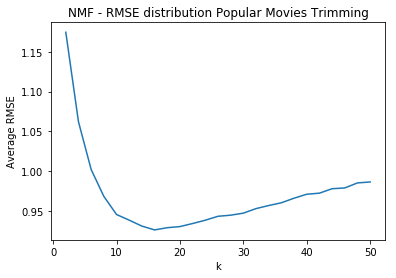

In [58]:
plot_distribution(RMSE_pop_movies_filtered_nmf,nmf_ks, title="NMF - RMSE distribution Popular Movies Trimming", x_label="k", y_label="Average RMSE")


In [59]:
# Question 20: Design a NNMF collaborative filter to predict the ratings of the
# movies in the unpopular movie trimmed test set and evaluate it's performance
# using 10-fold cross validation.Sweep k ( number of latent factors) from 2 to 50 in
# step sizes of 2, and for each k compute the average RMSE obtained by averaging
# the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
# Also, report the minimum average RMSE

In [60]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_unpop_movies_filtered_nmf = []
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=False)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = unpopular_movies_filtered(testset, frequency_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_unpop_movies_filtered_nmf.append(np.mean(temp_rsme))
    

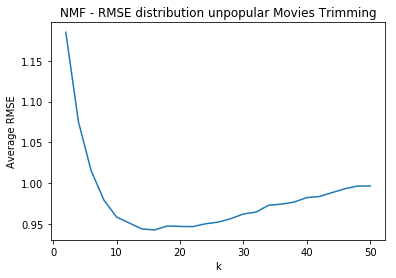

In [61]:
plot_distribution(RMSE_unpop_movies_filtered_nmf,nmf_ks, title="NMF - RMSE distribution unpopular Movies Trimming", x_label="k", y_label="Average RMSE")


In [62]:
# Question 21: Design a NNMF collaborative filter to predict the ratings of the
# movies in the high variance movie trimmed test set and evaluate it's perfor-
# mance using 10-fold cross validation.Sweep k ( number of latent factors) from 2
# to 50 in step sizes of 2, and for each k compute the average RMSE obtained by
# averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k
# (X-axis). Also, report the minimum average RMSE

In [63]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_high_var_movies_filtered_nmf = []
high_variance_movies = np.var(R_df_na, axis=0)
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=False)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = high_var_movies_filtered(testset, frequency_movies, high_variance_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_high_var_movies_filtered_nmf.append(np.mean(temp_rsme))

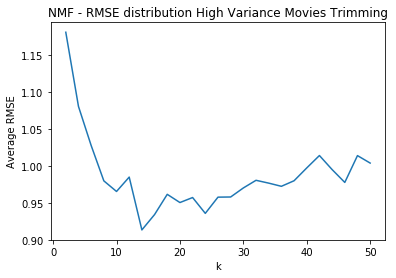

In [64]:
plot_distribution(RMSE_high_var_movies_filtered_nmf,nmf_ks, title="NMF - RMSE distribution High Variance Movies Trimming", x_label="k", y_label="Average RMSE")


In [65]:
# Question 22: Plot the ROC curves for the NNMF-based collaborative filter
# designed in question 17 for threshold values [2:5; 3; 3:5; 4]. For the ROC plot-
# ting use the optimal number of latent factors found in question 18. For each of
# the plots, also report the area under the curve (AUC) value.

In [66]:
ratings_thresholds = [2.5,3,3.5,4]

nmf_fprs = []
nmf_tprs = []
nmf_AUCs = []

for threshold in ratings_thresholds:
    nmf = NMF(n_factors=nmf_min_RMSE[0], biased=False) #min_RSME is from problem 11.
    trainset, testset = train_test_split(ratings_surprise_dataset, test_size=0.1)
    nmf.fit(trainset)
    pred = nmf.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold: #ratings threshold
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    nmf_fprs.append(fpr)
    nmf_tprs.append(tpr)
    nmf_AUCs.append(AUC)

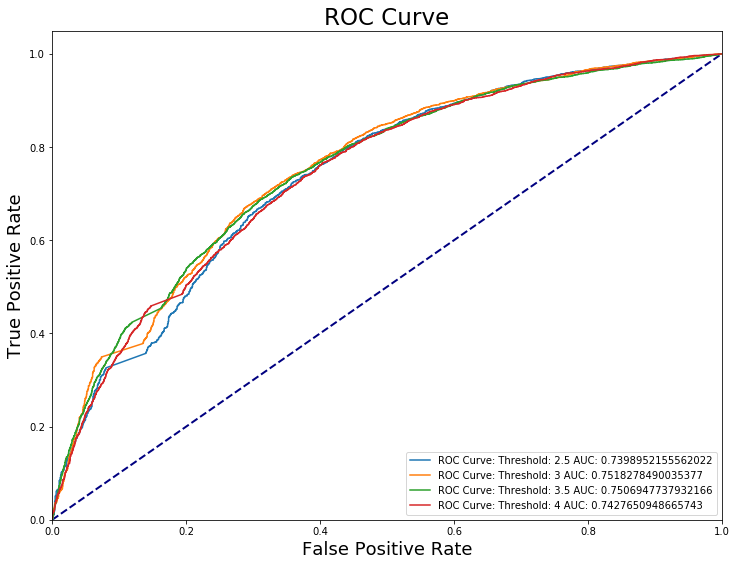

In [67]:
combined_roc_plotter(nmf_fprs,nmf_tprs,nmf_AUCs,ratings_thresholds)

In [68]:
# Question 23: Perform Non-negative matrix factorization on the ratings matrix
# R to obtain the factor matrices U and V , where U represents the user-latent
# factors interaction and V represents the movie-latent factors interaction (use k
# = 20). For each column of V , sort the movies in descending order and report
# the genres of the top 10 movies. Do the top 10 movies belong to a particular
# or a small collection of genre? Is there a connection between the latent factors
# and the movie genres?

In [69]:
Movies = pd.read_csv('ml-latest-small/movies.csv')

In [70]:
Movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [71]:
Movies[Movies['movieId'] == 3464]

,movieId,title,genres


In [72]:
import csv


In [73]:
with open('ml-latest-small/movies.csv', 'r', encoding='utf8') as f:
    reader = csv.reader(f, delimiter=',', quotechar='"')
    next(reader, None)
    movies = {int(movie[0]): movie[2] for movie in reader}
  
reader = Reader(sep=',', rating_scale=(0.0, 5.0), skip_lines=1)
allMoives = Dataset.load_from_file('ml-latest-small/ratings.csv', reader=reader)

In [74]:
movies[3738]

'Drama'

In [75]:
k, col = 20, 5

In [76]:
# nmf = NMF(n_factors=k)
# train_all_movies = allMoives.build_full_trainset()

In [77]:
# nmf.fit(train_all_movies)

In [78]:
# ids = [[] for _ in range(col)]
# for i in range(col):
#     factors = nmf.qi[:, i]
#     s = sorted([[i, factor] for i, factor in enumerate(factors)], key=lambda x:x[1], reverse=True)
    
#     for k in range(10): # top 10 movies
#         ids[i].append(s[k][0])
    
#     genres = [[] for _ in range(col)]
# #     print(ids)
    
#     for i in range(col):
#         for j in range(10):
#             print(ids[i][j])
#             genres[i].append(movies[int(train_all_movies.to_raw_iid(ids[i][j]))])
#     for i in range(col):
# #         print('Col ' + str(i+1) + ':')
#         for genre in genres[i]:
#             print(genre, end=', ')
#         print('')
# #     print("Finish finding top K!")

In [80]:
# Question 24: Design a MF with bias collaborative filter to predict the ratings of
# the movies in the MovieLens dataset and evaluate it's performance using 10-fold
# cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes
# of 2, and for each k compute the average RMSE and average MAE obtained
# by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE
# (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis).
# For solving this question, use the default value for the regularization parameter.

In [81]:
# NMFs
nmf_ks = np.arange(2,52,2)
nmf_mae_baised, nmf_rmse_biased = [],[]
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=True)
    cv = cross_validate(nmf, ratings_surprise_dataset,measures=['RMSE','MAE'],cv=10, verbose=False)
    nmf_rmse_biased.append(np.mean(cv['test_rmse']))
    nmf_mae_baised.append(np.mean(cv['test_mae']))
    
    
    

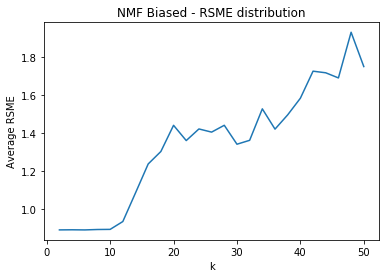

In [82]:
plot_distribution(nmf_rmse_biased, nmf_ks, title="NMF Biased - RSME distribution", x_label="k", y_label="Average RSME")

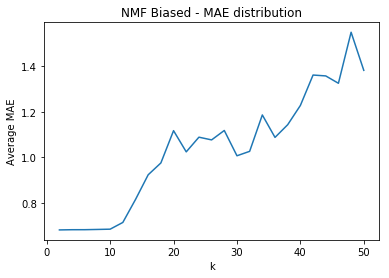

In [83]:
plot_distribution(nmf_mae_baised, nmf_ks, title="NMF Biased - MAE distribution", x_label="k", y_label="Average MAE")

In [84]:
# Question 25: Use the plot from question 24, to find the optimal number of
# latent factors. Optimal number of latent factors is the value of k that gives
# the minimum average RMSE or the minimum average MAE. Please report the
# minimum average RMSE and MAE.

In [85]:
#position where min RMSE
nmf_min_RMSE = [i for i, x in enumerate(nmf_rmse) if x == min(nmf_rmse)]
print(min(nmf_rmse_biased))
print(nmf_ks[nmf_min_RMSE]) #lowest k value

0.88805911166
[16]


In [86]:
#position where min MAE
nmf_min_MAE = [i for i, x in enumerate(nmf_mae) if x == min(nmf_mae)]
print(min(nmf_mae_baised))
print(nmf_ks[nmf_min_MAE]) # lowest k value

0.68163385222
[22]


In [87]:
# Question 26: Design a MF with bias collaborative filter to predict the ratings of
# the movies in the popular movie trimmed test set and evaluate it's performance
# using 10-fold cross validation.Sweep k ( number of latent factors) from 2 to 50 in
# step sizes of 2, and for each k compute the average RMSE obtained by averaging
# the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
# Also, report the minimum average RMSE

In [88]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_pop_movies_filtered_nmf_baised = []
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=True)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = popular_movies_filtered(testset, frequency_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_pop_movies_filtered_nmf_baised.append(np.mean(temp_rsme))

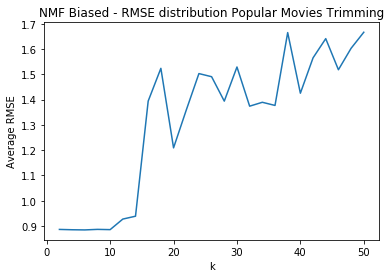

In [89]:
plot_distribution(RMSE_pop_movies_filtered_nmf_baised,nmf_ks, title="NMF Biased - RMSE distribution Popular Movies Trimming", x_label="k", y_label="Average RMSE")


In [90]:
# Question 27: Design a MF with bias collaborative filter to predict the rat-
# ings of the movies in the unpopular movie trimmed test set and evaluate it's
# performance using 10-fold cross validation.Sweep k ( number of latent factors)
# from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob-
# tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis)
# against k (X-axis). Also, report the minimum average RMSE

In [91]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_unpop_movies_filtered_nmf_biased = []
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=False)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = unpopular_movies_filtered(testset, frequency_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_unpop_movies_filtered_nmf_biased.append(np.mean(temp_rsme))
    

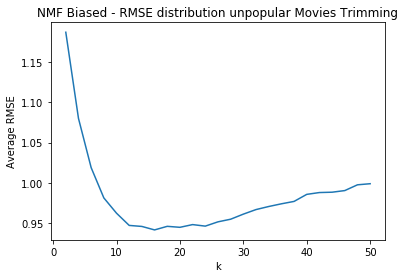

In [92]:
plot_distribution(RMSE_unpop_movies_filtered_nmf_biased,nmf_ks, title="NMF Biased - RMSE distribution unpopular Movies Trimming", x_label="k", y_label="Average RMSE")


In [93]:
# Question 28: Design a MF with bias collaborative filter to predict the rat-
# ings of the movies in the high variance movie trimmed test set and evaluate it's
# performance using 10-fold cross validation.Sweep k ( number of latent factors)
# from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob-
# tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis)
# against k (X-axis). Also, report the minimum average RMSE

In [94]:
%%capture

# define a cross-validation iterator
kf = KFold(n_splits=10)
RMSE_high_var_movies_filtered_nmf_biased = []
high_variance_movies = np.var(R_df_na, axis=0)
for k in range(2,52,2):
    nmf = NMF(n_factors=k, biased=True)
    temp_rsme = []
    for trainset, testset in kf.split(ratings_surprise_dataset):
        #train and test
        nmf.fit(trainset)
        filtered_testset = high_var_movies_filtered(testset, frequency_movies, high_variance_movies)
        pred = nmf.test(filtered_testset)
        #compute RMSE
        temp_rsme.append(accuracy.rmse(pred, verbose=False))
    RMSE_high_var_movies_filtered_nmf_biased.append(np.mean(temp_rsme))

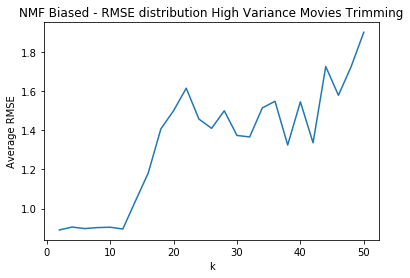

In [95]:
plot_distribution(RMSE_high_var_movies_filtered_nmf_biased,nmf_ks, title="NMF Biased - RMSE distribution High Variance Movies Trimming", x_label="k", y_label="Average RMSE")


In [97]:
# Question 29: Plot the ROC curves for the MF with bias collaborative filter
# designed in question 24 for threshold values [2:5; 3; 3:5; 4]. For the ROC plot-
# ting use the optimal number of latent factors found in question 25. For each of
# the plots, also report the area under the curve (AUC) value.

In [98]:
ratings_thresholds = [2.5,3,3.5,4]

nmf_fprs = []
nmf_tprs = []
nmf_AUCs = []

for threshold in ratings_thresholds:
    nmf = NMF(n_factors=nmf_min_RMSE[0], biased=True) #min_RSME is from problem 11.
    trainset, testset = train_test_split(ratings_surprise_dataset, test_size=0.1)
    nmf.fit(trainset)
    pred = nmf.test(testset)
    
    real_y = []
    est_y = []
    for i in range(len(pred)):
        est_y.append(pred[i].est)
        if testset[i][2] >= threshold: #ratings threshold
            real_y.append(1.0)
        else:
            real_y.append(0.0)
            
    fpr, tpr, thresholds = roc_curve(real_y, est_y)
    AUC = roc_auc_score(real_y, est_y)
    nmf_fprs.append(fpr)
    nmf_tprs.append(tpr)
    nmf_AUCs.append(AUC)

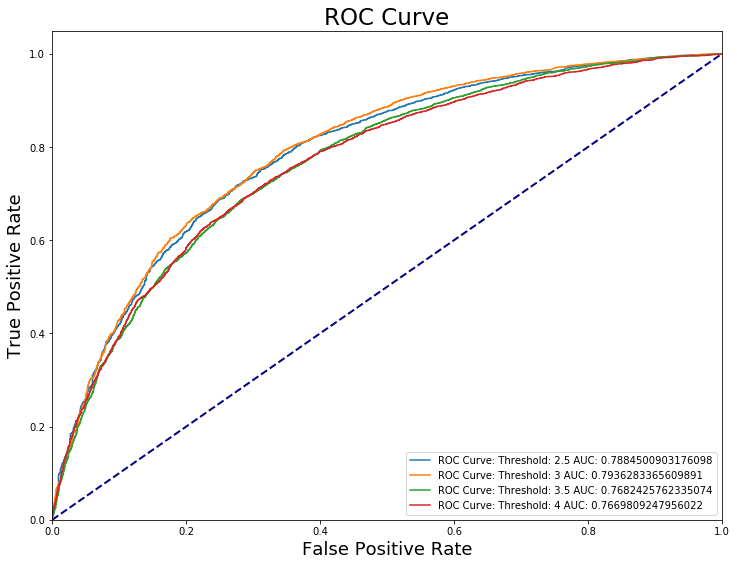

In [99]:
combined_roc_plotter(nmf_fprs,nmf_tprs,nmf_AUCs,ratings_thresholds)

In [ ]:
# Question 30: Design a naive collaborative filter to predict the ratings of the
# movies in the MovieLens dataset and evaluate it's performance using 10-fold
# cross validation. Compute the average RMSE by averaging the RMSE across
# all 10 folds. Report the average RMSE.

In [ ]:
# Question 31: Design a naive collaborative filter to predict the ratings of the
# movies in the popular movie trimmed test set and evaluate it's performance
# using 10-fold cross validation. Compute the average RMSE by averaging the
# RMSE across all 10 folds. Report the average RMSE.

In [ ]:
# Question 32: Design a naive collaborative filter to predict the ratings of the
# movies in the unpopular movie trimmed test set and evaluate it's performance
# using 10-fold cross validation. Compute the average RMSE by averaging the
# RMSE across all 10 folds. Report the average RMSE.

In [ ]:
# Question 33: Design a naive collaborative filter to predict the ratings of the
# movies in the high variance movie trimmed test set and evaluate it's perfor-
# mance using 10-fold cross validation. Compute the average RMSE by averaging
# the RMSE across all 10 folds. Report the average RMSE.

In [ ]:
# Question 34: Plot the ROC curves (threshold = 3) for the k-NN, NNMF, and
# MF with bias based collaborative filters in the same figure. Use the figure to
# compare the performance of the filters in predicting the ratings of the movies.

In [ ]:
# Question 35: Precision and Recall are defined by the mathematical expres-
# sions given by equations 12 and 13 respectively. Please explain the meaning of
# precision and recall in your own words.

In [ ]:
# Question 36: Plot average precision (Y-axis) against t (X-axis) for the rank-
# ing obtained using k-NN collaborative filter predictions. Also, plot the average
# recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average
# recall (X-axis). Use the k found in question 11 and sweep t from 1 to 25 in step
# sizes of 1. For each plot, brie
# y comment on the shape of the plot.

In [ ]:
# Question 37: Plot average precision (Y-axis) against t (X-axis) for the rank-
# ing obtained using NNMF-based collaborative filter predictions. Also, plot the
# average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against
# average recall (X-axis). Use optimal number of latent factors found in question
# 18 and sweep t from 1 to 25 in step sizes of 1. For each plot, brie
# y comment
# on the shape of the plot.

In [ ]:
# Question 38: Plot average precision (Y-axis) against t (X-axis) for the ranking
# obtained using MF with bias-based collaborative filter predictions. Also, plot
# the average recall (Y-axis) against t (X-axis) and average precision (Y-axis)
# against average recall (X-axis). Use optimal number of latent factors found in
# question 25 and sweep t from 1 to 25 in step sizes of 1. For each plot, brie
# y
# comment on the shape of the plot.

In [ ]:
# Question 39: Plot the precision-recall curve obtained in questions 36,37, and
# 38 in the same figure. Use this figure to compare the relevance of the recom-
# mendation list generated using k-NN, NNMF, and MF with bias predictions.